# Calculating gravity from topographic raster data

This code is based on the following tutorial of the ***Fatiando*** project:

[Gravitational effect of topography | Harmonica](https://www.fatiando.org/harmonica/latest/gallery/forward/prisms_topo_gravity.html)

In [1]:
%matplotlib inline
from IPython.display import display, Math

In [2]:
import ensaio
import pygmt
import pyproj
import verde as vd
import xarray as xr
import numpy as np
import harmonica as hm
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from matplotlib.colors import LinearSegmentedColormap

In [3]:
cmap_terrain = plt.get_cmap('terrain')

cmap_terrain_crust = LinearSegmentedColormap.from_list(
    'terrain_crust', cmap_terrain(np.linspace(0.25, 0.75, 256))
)

### 1. Import DTM (Digital Terrain Model)

In [4]:
filename = '../data/Sopetran_DTM.tif' # DTM taken from colombiaenmapas.gov.co
topography = xr.load_dataset(filename, engine="rasterio")
topography

<xarray.Dataset> Size: 537MB
Dimensions:      (band: 1, x: 10008, y: 13408)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB 4.687e+06 4.687e+06 ... 4.707e+06 4.707e+06
  * y            (y) float64 107kB 2.292e+06 2.292e+06 ... 2.265e+06 2.265e+06
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 537MB nan nan nan nan ... nan nan nan nan

##### Sort the dataset

In [5]:
topography = topography.sortby(['x', 'y'])
topography.band_data[0, :, :]

<xarray.DataArray 'band_data' (y: 13408, x: 10008)> Size: 537MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(13408, 10008), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 80kB 4.687e+06 4.687e+06 ... 4.707e+06 4.707e+06
  * y            (y) float64 107kB 2.265e+06 2.265e+06 ... 2.292e+06 2.292e+06
    spatial_ref  int64 8B 0
Attributes:
    DataType:                Generic
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  500742.8669970009
    STATISTICS_MAXIMUM:      3112.6879882812
    STATISTICS_MEAN:         1252.8209950516
    STATISTICS_MEDIAN:       1029,882980
    STATISTICS_MINIMUM:      443.76699829102
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       707.63187251353

In [6]:
display(Math(f"\\delta_x = {np.diff(topography.x).mean()},\\ \\delta_y = {np.diff(topography.y).mean()}"))

<IPython.core.display.Math object>

##### Plot topography

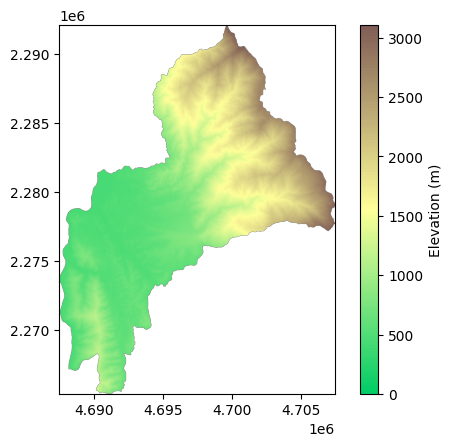

In [7]:
plt.imshow(
    topography.band_data[0, ::10, ::10],
    cmap=cmap_terrain_crust, 
    origin='lower', 
    vmin=0, 
    extent=[topography.x.min(), 
        topography.x.max(), 
        topography.y.min(), 
        topography.y.max()]
    )

plt.colorbar(label="Elevation (m)")
plt.show()

### 2. Select Domain to forward modelling

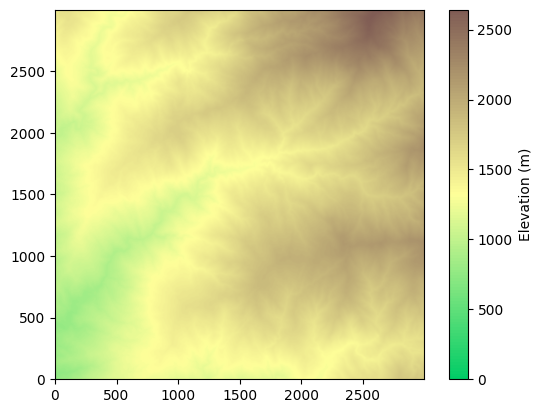

In [8]:
region = (4.697e6, 4.703e6, 2.279e6, 2.285e6)
#region = (4.687e6, 4.707e6, 2.265e6, 2.292e6)

topography_domain = topography.sel(
    x=slice(*region[:2]),
    y=slice(*region[2:]),
)


surface = topography_domain.band_data[0, :, :]
plt.imshow(surface, cmap=cmap_terrain_crust, origin='lower', vmin=0)
plt.colorbar(label="Elevation (m)")

##### Subsampling Domain

In [9]:
sampling = 10
#sampling = 80
topography_domain_subsampled = topography_domain.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)
topography_domain_subsampled

<xarray.Dataset> Size: 365kB
Dimensions:      (band: 1, x: 300, y: 300)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 4.697e+06 4.697e+06 ... 4.703e+06 4.703e+06
  * y            (y) float64 2kB 2.279e+06 2.279e+06 ... 2.285e+06 2.285e+06
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 360kB 746.7 755.9 ... 2.441e+03 2.443e+03

In [10]:
display(Math(f"\\delta_x = {np.diff(topography_domain_subsampled.x).mean()},\\ \\delta_y = {np.diff(topography_domain_subsampled.y).mean()}"))

<IPython.core.display.Math object>

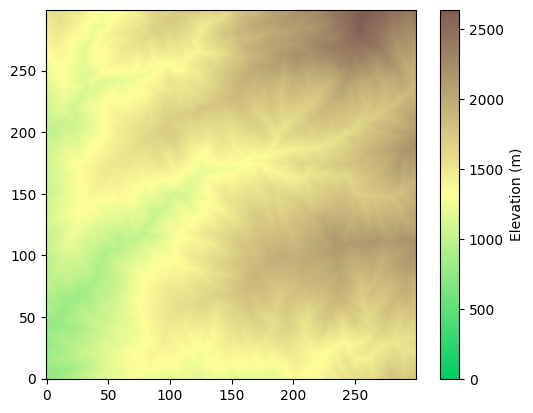

In [11]:
surface = topography_domain_subsampled.band_data[0, :, :]
plt.imshow(surface, cmap=cmap_terrain_crust, origin='lower', vmin=0)
plt.colorbar(label="Elevation (m)")

##### Compute density

In [12]:
density = 2670.0 * np.ones_like(surface)
density = np.where(surface >= 0, density, 1000 - 2900)
density

array([[2670., 2670., 2670., ..., 2670., 2670., 2670.],
       [2670., 2670., 2670., ..., 2670., 2670., 2670.],
       [2670., 2670., 2670., ..., 2670., 2670., 2670.],
       ...,
       [2670., 2670., 2670., ..., 2670., 2670., 2670.],
       [2670., 2670., 2670., ..., 2670., 2670., 2670.],
       [2670., 2670., 2670., ..., 2670., 2670., 2670.]],
      shape=(300, 300), dtype=float32)

##### NaN to num

In [13]:
surface = surface.fillna(0)
surface

<xarray.DataArray 'band_data' (y: 300, x: 300)> Size: 360kB
array([[ 746.748  ,  755.877  ,  767.554  , ..., 1751.513  , 1756.002  ,
        1750.437  ],
       [ 743.07904,  746.265  ,  755.301  , ..., 1749.856  , 1756.481  ,
        1743.908  ],
       [ 748.073  ,  749.406  ,  747.586  , ..., 1756.466  , 1750.718  ,
        1740.3469 ],
       ...,
       [1512.9359 , 1523.3579 , 1535.7319 , ..., 2411.55   , 2420.582  ,
        2422.023  ],
       [1518.245  , 1524.3629 , 1535.2169 , ..., 2427.613  , 2430.358  ,
        2433.533  ],
       [1523.143  , 1533.153  , 1541.037  , ..., 2439.3281 , 2440.929  ,
        2442.587  ]], shape=(300, 300), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB 4.697e+06 4.697e+06 ... 4.703e+06 4.703e+06
  * y            (y) float64 2kB 2.279e+06 2.279e+06 ... 2.285e+06 2.285e+06
    spatial_ref  int64 8B 0
Attributes:
    DataType:                Generic
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  500742.8669970009
    STATISTICS_MAXIMUM:      3112.6879882812
    STATISTICS_MEAN:         1252.8209950516
    STATISTICS_MEDIAN:       1029,882980
    STATISTICS_MINIMUM:      443.76699829102
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       707.63187251353

### 3. Select region of interest

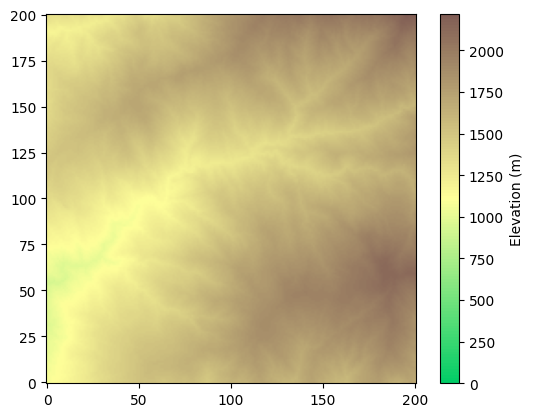

In [23]:
#region_ROI = (4.698e6, 4.702e6, 2.280e6, 2.284e6)
spacing = 20
#spacing = 80
reduction = 1000
region_ROI = region_ROI = tuple(val + reduction if i % 2 == 0 else val - reduction for i, val in enumerate(region))
coordinates_ROI = vd.grid_coordinates(region=region_ROI, spacing=spacing)

x = topography_domain_subsampled.x
y = topography_domain_subsampled.y

surface_interpolated = RectBivariateSpline(x, y, surface.T)
surface_ROI = surface_interpolated.ev(coordinates_ROI[0], coordinates_ROI[1])

plt.imshow(surface_ROI, cmap=cmap_terrain_crust, origin='lower', vmin=0)
plt.colorbar(label="Elevation (m)")
plt.show()

### 4. Calculate gravity

In [24]:
prisms = hm.prism_layer(
    coordinates=(x, y),
    surface=surface,
    reference=0,
    properties={"density": density},
)

In [25]:
prisms_gravity = prisms.prism_layer.gravity((coordinates_ROI[0], coordinates_ROI[1], surface_ROI), field="g_z")
prisms_gravity.shape

(201, 201)

In [26]:
# merge into a dataset
grid = vd.make_xarray_grid(
    (coordinates_ROI[0], coordinates_ROI[1]),
    prisms_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

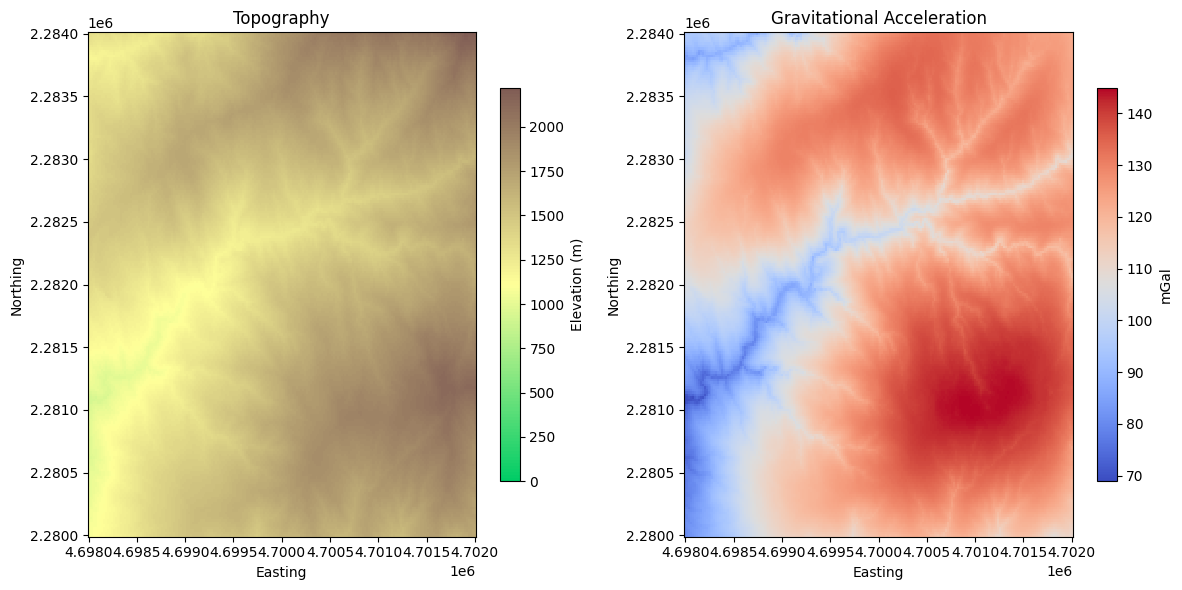

In [27]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.pcolormesh(coordinates_ROI[0], coordinates_ROI[1], surface_ROI, cmap=cmap_terrain_crust, vmin=0)
plt.colorbar(im1, ax=ax1, label="Elevation (m)", shrink=0.78)
ax1.set_title("Topography")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")

im2 = ax2.pcolormesh(coordinates_ROI[0], coordinates_ROI[1], grid.gravity, cmap="coolwarm")
plt.colorbar(im2, ax=ax2, label="mGal", shrink=0.78)
ax2.set_title("Gravitational Acceleration")
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")

fig2.tight_layout()